<a href="https://colab.research.google.com/github/utkussaglam/NLPandTheWeb/blob/main/HW4Kopie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset preparation scripts from PS8

In [1]:
import random
import numpy as np
import torch

np.random.seed(1337)
random.seed(1337)
torch.manual_seed(1337)
torch.cuda.manual_seed_all(1337)  # If using CUDA

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is set to: {device}")

# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

data = torch.tensor(encode(text), dtype=torch.long)

n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

block_size = 8
train_data[:block_size+1]

x = train_data[:block_size]
y = train_data[1:block_size+1]

# batch processing the data to parallelize(make faster) the computations.
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
xb = xb.to(device)
yb = yb.to(device)

Device is set to: cpu
--2025-01-13 19:53:34--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2025-01-13 19:53:34 (18.0 MB/s) - ‘input.txt’ saved [1115394/1115394]



# TASK1: Implement GRU (10 points)

Implement the Gated Recurent Unit (GRU) architecture using the RNN source-course from practice session 8 (PS).

1. Update Gate:

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$$

where  $z_t$  is the update gate at time step  $t$ ,  $\sigma$  is the sigmoid function,  $W_z$  is the weight matrix for the update gate,  $h_{t-1}$  is the previous hidden state,  $x_t$  is the input at time step $t$.

2.	Reset Gate:

$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$$

where  $r_t$  is the reset gate at time step  $t$ ,  $W_r$  is the weight matrix for the reset gate.

3.	Candidate Hidden State:

$$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t])$$

where  $\tilde{h}_t$  is the candidate hidden state at time step  $t$ ,  $\odot$  denotes element-wise multiplication,  $W_h$  is the weight matrix for the candidate hidden state.

4.	Final Hidden State:

$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

where  $h_t$  is the final hidden state at time step  $t$ .

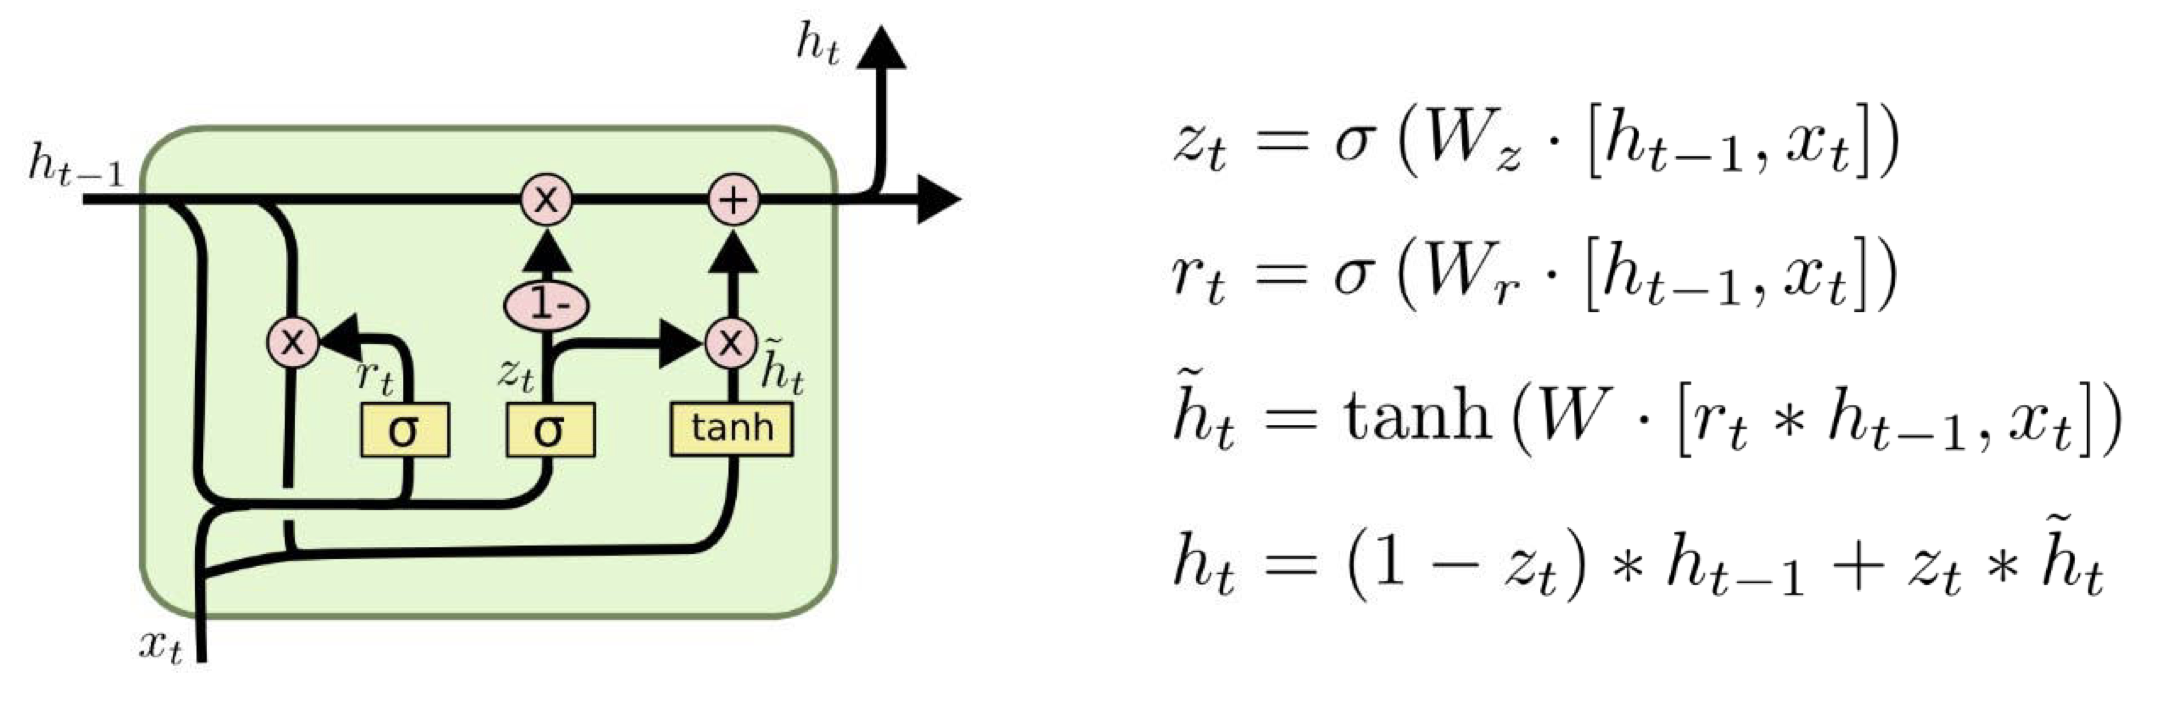

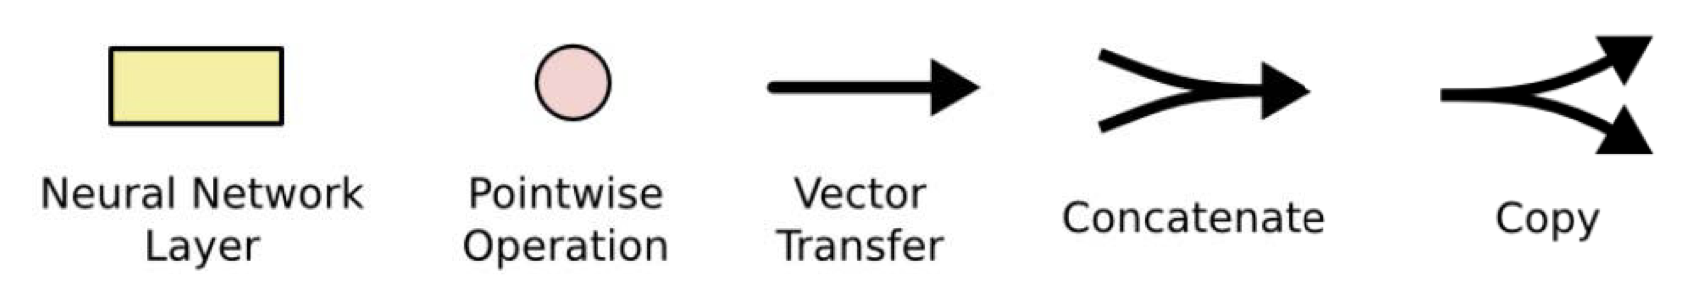

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, device='cpu') -> None:
        super().__init__()
        ## YOUR_CODE_STARTS_HERE
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.device = device

        # Embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, device=device)

        # Weight matrices for GRU gates
        self.Wz = nn.Linear(embedding_dim + hidden_dim, hidden_dim, device=device)  # Update gate
        self.Wr = nn.Linear(embedding_dim + hidden_dim, hidden_dim, device=device)  # Reset gate
        self.Wh = nn.Linear(embedding_dim + hidden_dim, hidden_dim, device=device)  # Candidate hidden state

        # Output layer
        self.Whv = nn.Linear(hidden_dim, vocab_size, device=device)
        ## YOUR_CODE_ENDS_HERE

    def forward(self, idx, targets=None) -> tuple[int, int]:
        ## YOUR_CODE_STARTS_HERE
        B, T = idx.size()
        embeds = self.embeddings(idx)  # (B, T, E)

        hidden = torch.zeros(B, self.hidden_dim, device=self.device)  # Initialize hidden state to zeros

        logits_list = []
        for t in range(T):
            xt = embeds[:, t]  # Extract input for current time step

            # Concatenate input and previous hidden state
            combined = torch.cat((hidden, xt), dim=1)

            # Compute gates and candidate hidden state
            zt = torch.sigmoid(self.Wz(combined))  # Update gate
            rt = torch.sigmoid(self.Wr(combined))  # Reset gate
            candidate_hidden = torch.tanh(self.Wh(torch.cat((rt * hidden, xt), dim=1)))  # Candidate hidden state

            # Compute new hidden state
            hidden = (1 - zt) * hidden + zt * candidate_hidden

            # Compute output logits
            logits = self.Whv(hidden)  # Shape: (B, vocab_size)
            logits_list.append(logits.unsqueeze(1))  # Add time dimension: (B, 1, V)

        # Combine logits across all time steps
        logits = torch.cat(logits_list, dim=1)  # Shape: (B, T, V)

        # Compute loss if targets are provided
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) if targets is not None else None

        return logits, loss
        ## YOUR_CODE_ENDS_HERE
        pass

    def generate(self, idx, max_new_tokens) -> torch.Tensor:
        ## YOUR_CODE_STARTS_HERE
        B, T = idx.size()
        hidden = torch.zeros(B, self.hidden_dim, device=self.device)  # Initialize hidden state to zeros

        outputs = [idx]

        for _ in range(max_new_tokens):
            current_idx = outputs[-1]
            embeds = self.embeddings(current_idx).squeeze(1)  # Shape: (B, E)

            # Concatenate input and previous hidden state
            combined = torch.cat((hidden, embeds), dim=1)

            # Compute gates and candidate hidden state
            zt = torch.sigmoid(self.Wz(combined))  # Update gate
            rt = torch.sigmoid(self.Wr(combined))  # Reset gate
            candidate_hidden = torch.tanh(self.Wh(torch.cat((rt * hidden, embeds), dim=1)))  # Candidate hidden state

            # Compute new hidden state
            hidden = (1 - zt) * hidden + zt * candidate_hidden

            # Generate next token
            logits = self.Whv(hidden)  # Shape: (B, vocab_size)
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)  # Sample next token
            outputs.append(next_idx)

        # Concatenate along sequence dimension
        generated_seq = torch.cat(outputs, dim=1)
        return generated_seq

        ## YOUR_CODE_ENDS_HERE
        pass

In [4]:
gru_model = GRULanguageModel(vocab_size, embedding_dim=50, hidden_dim=128)

In [5]:
## RESULT_CHECKING_POINT
print(gru_model)

GRULanguageModel(
  (embeddings): Embedding(65, 50)
  (Wz): Linear(in_features=178, out_features=128, bias=True)
  (Wr): Linear(in_features=178, out_features=128, bias=True)
  (Wh): Linear(in_features=178, out_features=128, bias=True)
  (Whv): Linear(in_features=128, out_features=65, bias=True)
)


In [6]:
logits, loss = gru_model(xb, yb)

In [7]:
## RESULT_CHECKING_POINT
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.1319, grad_fn=<NllLossBackward0>)


In [8]:
output = gru_model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)
print(decode(output.tolist()[0]))


-L3cDJlCcL3YUsubwcHdSMoQpxPoWlCnsWLscuMEctXYYFHygh$Cbh$Siyriakx YlDyEG&X,OInvZpglQgQifhhoiXJw
pLVPx&


### Training

In [9]:
import torch
from tqdm import tqdm

# Adjust the learning rate and optimizer
optimizer = torch.optim.AdamW(gru_model.parameters(), lr=5e-4)

losses = []
for step in tqdm(range(100)):  # Adjust the number of steps as needed
    x, y = get_batch("train")  # Make sure this function is implemented correctly
    x, y = x.to(device), y.to(device)

    logits, loss = gru_model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(gru_model.parameters(), max_norm=1)  # Gradient clipping
    optimizer.step()

    losses.append(loss.item())

print()

100%|██████████| 100/100 [00:01<00:00, 93.82it/s]

In [10]:
## RESULT_CHECKING_POINT
print(loss.item())

3.006697177886963


In [11]:
output = gru_model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)
print(decode(output.tolist()[0]))


:Mrxey he
ri drodndeGt hounont hedroowhtl hegrre k   cnh o l nwowvi eiprtI:ifeegl
Ir
edhrnyu i
Luhk 


# TASK2: Implement LSTM (10 points)

Long Short-Term Memory (LSTM) using the RNN source-course from practice session 8 (PS).


1.	Forget Gate:

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t])$$

where  $f_t$  is the forget gate activation at time step  $t$ ,  $\sigma$  is the sigmoid function,  $W_f$  is the weight matrix for the forget gate,  $h_{t-1}$  is the previous hidden state,  $x_t$  is the input at time step  $t$.

2.	Input Gate:

$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t])$$

where  $i_t$  is the input gate activation at time step  $t$ ,  $W_i$  is the weight matrix for the input gate.

3.	Cell State Candidate:

$$\tilde{C}t = \tanh(W_C \cdot [h{t-1}, x_t])$$

where  $\tilde{C}_t$  is the candidate for the cell state at time step  $t$ ,  $W_C$  is the weight matrix for the cell state candidate.

4.	Cell State Update:

$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}t$$

where  $C_t$  is the updated cell state at time step  $t$ ,  $C_{t-1}$  is the previous cell state, and  $\odot$  denotes element-wise multiplication.

5.	Output Gate:

$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t])$$

where  $o_t$  is the output gate activation at time step  $t$ ,  $W_o$  is the weight matrix for the output gate.

6.	Final Hidden State:

$$h_t = o_t \odot \tanh(C_t)$$

where  $h_t$  is the final hidden state at time step  $t$ .


> Please ignore the bias terms in the figure

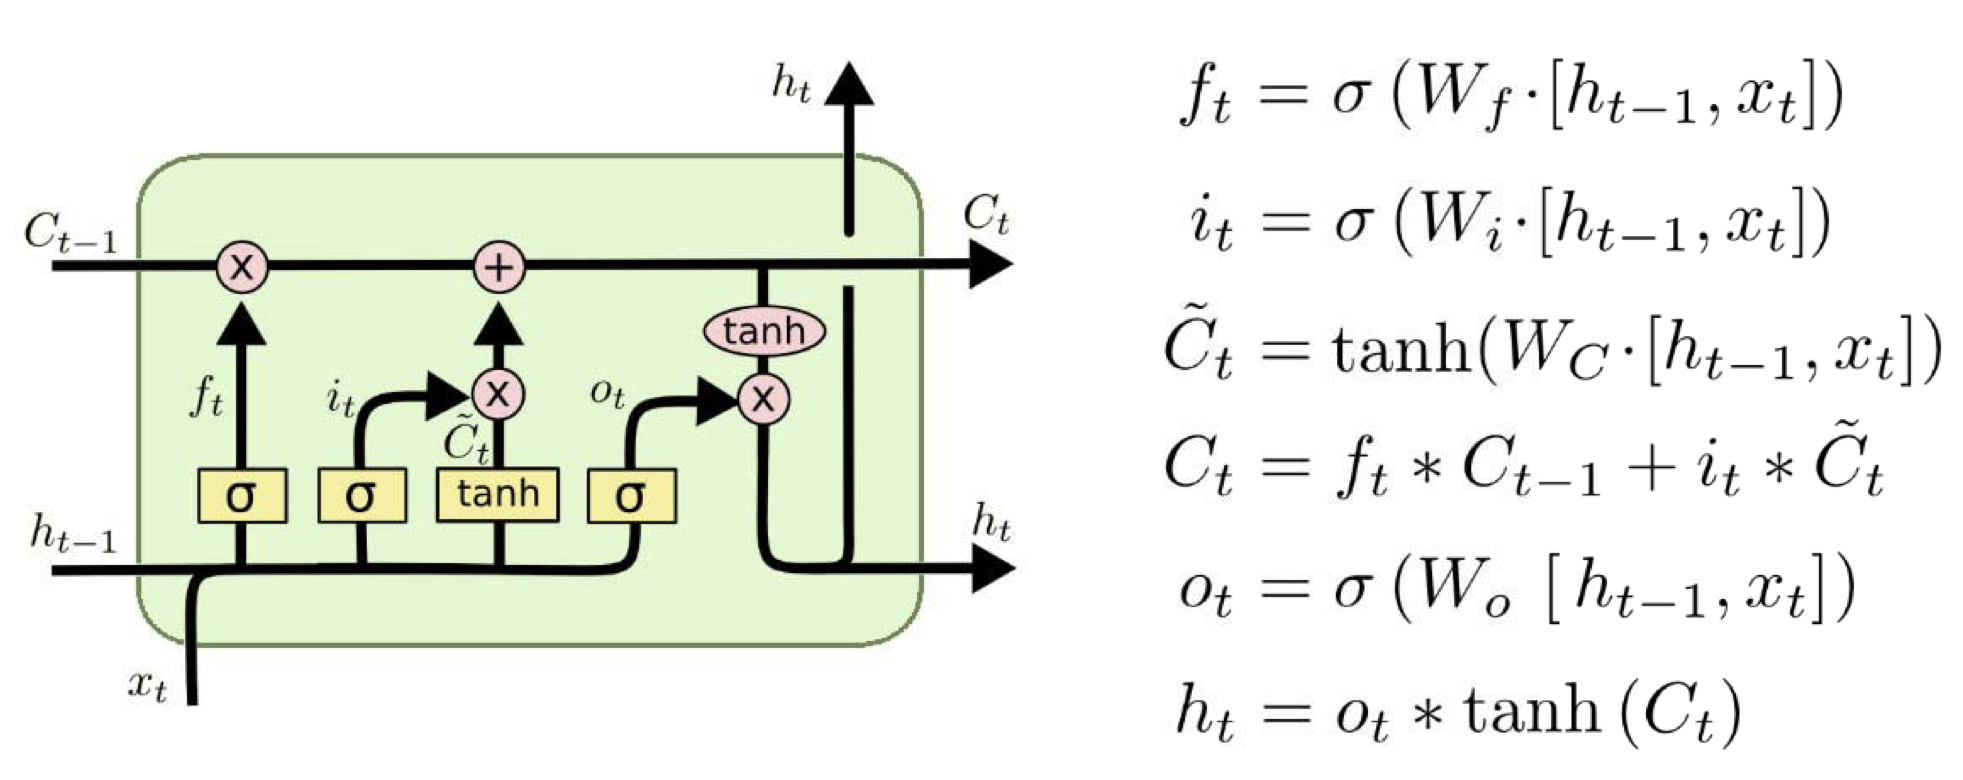

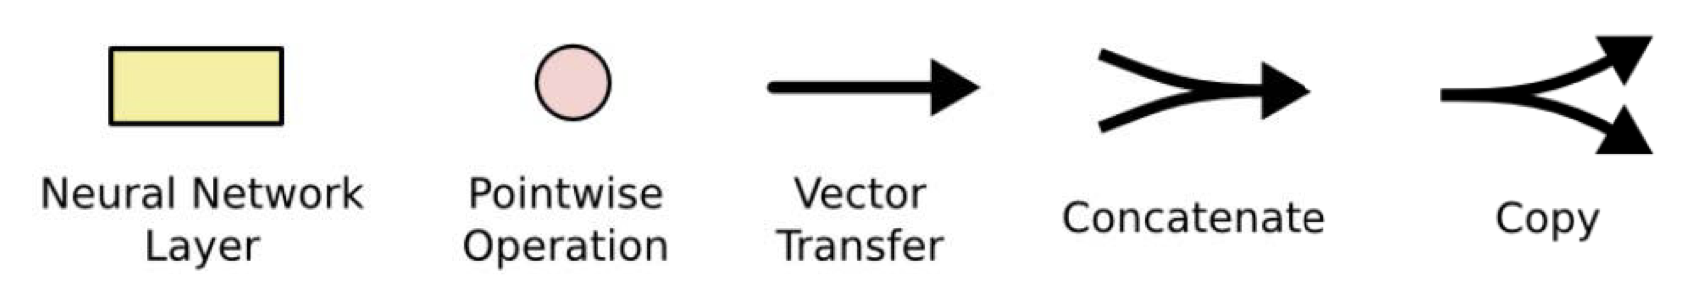

In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, device='cpu') -> None:
        super().__init__()
        ## YOUR_CODE_STARTS_HERE
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.device = device

        # Embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, device=device)

        # LSTM gates weight matrices
        self.Wf = nn.Linear(embedding_dim + hidden_dim, hidden_dim, device=device)  # Forget gate
        self.Wi = nn.Linear(embedding_dim + hidden_dim, hidden_dim, device=device)  # Input gate
        self.WC = nn.Linear(embedding_dim + hidden_dim, hidden_dim, device=device)  # Cell state candidate
        self.Wo = nn.Linear(embedding_dim + hidden_dim, hidden_dim, device=device)  # Output gate

        # Output layer
        self.Whv = nn.Linear(hidden_dim, vocab_size, device=device)
        ## YOUR_CODE_ENDS_HERE
        pass

    def forward(self, idx, targets=None) -> tuple[int, int]:
        ## YOUR_CODE_STARTS_HERE
        B, T = idx.size()
        embeds = self.embeddings(idx)  # (B, T, embedding_dim)

        hidden = torch.zeros(B, self.hidden_dim, device=self.device)  # Initialize hidden state
        cell = torch.zeros(B, self.hidden_dim, device=self.device)  # Initialize cell state

        logits_list = []
        for t in range(T):
            xt = embeds[:, t]  # Input at time step t

            # Concatenate input and previous hidden state
            combined = torch.cat((hidden, xt), dim=1)

            # Compute gates and candidate cell state
            ft = torch.sigmoid(self.Wf(combined))  # Forget gate
            it = torch.sigmoid(self.Wi(combined))  # Input gate
            C_tilde = torch.tanh(self.WC(combined))  # Cell state candidate
            ot = torch.sigmoid(self.Wo(combined))  # Output gate

            # Update cell state and hidden state
            cell = ft * cell + it * C_tilde
            hidden = ot * torch.tanh(cell)

            # Compute output logits
            logits = self.Whv(hidden)  # Shape: (B, vocab_size)
            logits_list.append(logits.unsqueeze(1))  # Add time dimension: (B, 1, vocab_size)

        # Combine logits across all time steps
        logits = torch.cat(logits_list, dim=1)  # Shape: (B, T, vocab_size)

        # Compute loss if targets are provided
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) if targets is not None else None

        return logits, loss
        ## YOUR_CODE_ENDS_HERE
        pass

    def generate(self, idx, max_new_tokens) -> torch.Tensor:
        ## YOUR_CODE_STARTS_HERE
        B, T = idx.size()
        hidden = torch.zeros(B, self.hidden_dim, device=self.device)  # Initialize hidden state
        cell = torch.zeros(B, self.hidden_dim, device=self.device)  # Initialize cell state

        outputs = [idx]

        for _ in range(max_new_tokens):
            current_idx = outputs[-1]
            embeds = self.embeddings(current_idx).squeeze(1)  # Shape: (B, embedding_dim)

            # Concatenate input and previous hidden state
            combined = torch.cat((hidden, embeds), dim=1)

            # Compute gates and candidate cell state
            ft = torch.sigmoid(self.Wf(combined))  # Forget gate
            it = torch.sigmoid(self.Wi(combined))  # Input gate
            C_tilde = torch.tanh(self.WC(combined))  # Cell state candidate
            ot = torch.sigmoid(self.Wo(combined))  # Output gate

            # Update cell state and hidden state
            cell = ft * cell + it * C_tilde
            hidden = ot * torch.tanh(cell)

            # Generate next token
            logits = self.Whv(hidden)  # Shape: (B, vocab_size)
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)  # Sample next token
            outputs.append(next_idx)

        # Concatenate along sequence dimension
        generated_seq = torch.cat(outputs, dim=1)
        return generated_seq

        ## YOUR_CODE_ENDS_HERE
        pass

In [13]:
lstm_model = LSTMLanguageModel(vocab_size, embedding_dim=50, hidden_dim=128)

In [14]:
## RESULT_CHECKING_POINT
print(lstm_model)

LSTMLanguageModel(
  (embeddings): Embedding(65, 50)
  (Wf): Linear(in_features=178, out_features=128, bias=True)
  (Wi): Linear(in_features=178, out_features=128, bias=True)
  (WC): Linear(in_features=178, out_features=128, bias=True)
  (Wo): Linear(in_features=178, out_features=128, bias=True)
  (Whv): Linear(in_features=128, out_features=65, bias=True)
)


In [15]:
logits, loss = lstm_model(xb, yb)

In [16]:
## RESULT_CHECKING_POINT
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.2033, grad_fn=<NllLossBackward0>)


In [17]:
output = lstm_model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)
print(decode(output.tolist()[0]))


EcyouLWuG?H$ZxIGkXcxez';'qvDf!fdWjVlnq3Zg'hSUqYrUbaKiU:?SFp!W3ZOMzGZlNSV-VHxK!Bm-otPBm!jt'KtZirZYVRe


### Training

In [18]:
import torch
from tqdm import tqdm

# Adjust the learning rate and optimizer
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=5e-4)

losses = []
for step in tqdm(range(100)):  # Adjust the number of steps as needed
    x, y = get_batch("train")  # Make sure this function is implemented correctly
    x, y = x.to(device), y.to(device)

    logits, loss = lstm_model(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1)  # Gradient clipping
    optimizer.step()

    losses.append(loss.item())

print()

100%|██████████| 100/100 [00:01<00:00, 70.90it/s]

In [19]:
## RESULT_CHECKING_POINT
print(loss.item())

3.2231931686401367


In [20]:
output = lstm_model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)
print(decode(output.tolist()[0]))


m:n
 wrei mv.eJn hso seewnenowwooin o rHh gugpsn tcs tsehoorn othhopFrieneebAinee tl aee oie i Loo 

